In [1]:
!pip install segmentation_models_pytorch wandb dataset pytorch_lightning torchsummary torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=157b20bfe870673f68ce59bb5894c6c17a87876bc2d62ec801ac193bf0438b45
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e2ee0e4fb1280381b4e743a9ea35ed423b0dcdb28a70a4501a9ea1adb1e0b693
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: sqlalchemy
    Found existing installa

In [2]:
import os
import torch
import numpy as np
import random
import glob
import h5py
import yaml
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer  # Import Trainer here
import torchmetrics
import segmentation_models_pytorch as smp
import wandb

In [3]:
# Set CUDA settings
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.set_float32_matmul_precision('high')

# Load the configuration file
config = """
model_config:
  model_type: "vgg16"
  in_channels: 14
  num_classes: 1
  encoder_weights: "imagenet"
  wce_weight: 0.5

dataset_config:
  num_classes: 1
  num_channels: 14
  channels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14]
  normalize: False

train_config:
  dataset_path: "/kaggle/input/landslide4sense/TrainData"
  checkpoint_path: "checkpoints"
  seed: 42
  train_val_split: 0.8
  batch_size: 16
  num_epochs: 100
  lr: 0.001
  device: "cuda:0"
  save_config: True
  experiment_name: "VGG16"

logging_config:
  wandb_project: "Land4Sense"
  wandb_entity: "Silvamillion"
"""

config = yaml.safe_load(config)
# Set the random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Utils
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    set_seed(42 + worker_id)

# Dataset
class DatasetLandslide(Dataset):
    def __init__(self, path):
        self.train_paths, self.mask_paths = self.read_data(path)

    def read_data(self, path):
        TRAIN_PATH = f"{path}/img/*.h5"
        TRAIN_MASK = f'{path}/mask/*.h5'
        all_train = sorted(glob.glob(TRAIN_PATH))
        all_mask = sorted(glob.glob(TRAIN_MASK))
        return all_train, all_mask

    def __len__(self):
        return len(self.train_paths)

    def __getitem__(self, idx):
        channels = config["dataset_config"]["channels"]
        TRAIN_XX = np.zeros((128, 128, len(channels)))

        with h5py.File(self.train_paths[idx]) as hdf:
            data = np.array(hdf.get('img'))
            data[np.isnan(data)] = 0.000001

            for i, channel in enumerate(channels):
                TRAIN_XX[:, :, i] = data[:, :, channel-1]  # Change here to use 0-based indexing
                if self.train_paths[idx].find("image") != -1:
                    TRAIN_XX[:, :, i] = data[:, :, channel-1]

            img = TRAIN_XX.transpose((2, 0, 1))  # Transponemos para tener (C, H, W)
            if config["dataset_config"]["normalize"]:
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

        mask = np.array([])
        if self.mask_paths != []:
            with h5py.File(self.mask_paths[idx]) as hdf:
                mask = np.array(hdf.get('mask'))
                mask = mask[np.newaxis, :]  # Añadir dimensión de canal

        return torch.from_numpy(img).float(), torch.from_numpy(mask).float()  # Convertimos a tensores de PyTorch

In [4]:
#Model
class smp_model_vgg16(nn.Module):
    def __init__(self, in_channels, out_channels, model_type, num_classes, encoder_weights):
        super(smp_model_vgg16, self).__init__()
        
        if model_type.lower() == "vgg16":
            # Use VGG16 pre-trained model as encoder
            self.model = smp.Unet(
                encoder_name='vgg16',
                encoder_weights=encoder_weights,
                in_channels=in_channels,  # The number of input channels, which is 14
                classes=num_classes,       # Output classes, which is 1
            )

    def forward(self, x):
        return self.model(x)

class LandslideModel(pl.LightningModule):
    def __init__(self, alpha=0.5):
        super(LandslideModel, self).__init__()

        model_type = config['model_config']['model_type']
        in_channels = config['model_config']['in_channels']
        num_classes = config['model_config']['num_classes']
        self.alpha = alpha  # Assign the alpha value to the class variable
        self.lr = config['train_config']['lr']

        if model_type == 'unet':
            self.model = UNet(in_channels=in_channels, out_channels=num_classes)
        else:
            encoder_weights = config['model_config']['encoder_weights']
            # Use the custom smp_model_vgg16 instead of smp_model
            self.model = smp_model_vgg16(in_channels=in_channels, 
                                          out_channels=num_classes, 
                                          model_type=model_type, 
                                          num_classes=num_classes, 
                                          encoder_weights=encoder_weights)

        self.weights = torch.tensor([5], dtype=torch.float32).to(self.device)
        self.wce = nn.BCELoss(weight=self.weights)

        self.train_f1 = torchmetrics.F1Score(task='binary')
        self.val_f1 = torchmetrics.F1Score(task='binary')

        self.train_precision = torchmetrics.Precision(task='binary')
        self.val_precision = torchmetrics.Precision(task='binary')

        self.train_recall = torchmetrics.Recall(task='binary')
        self.val_recall = torchmetrics.Recall(task='binary')

        self.train_iou = torchmetrics.JaccardIndex(task='binary')
        self.val_iou = torchmetrics.JaccardIndex(task='binary')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.sigmoid(self(x))

        wce_loss = self.wce(y_hat, y)
        dice = dice_loss(y_hat, y)

        combined_loss = (1 - self.alpha) * wce_loss + self.alpha * dice

        precision = self.train_precision(y_hat, y)
        recall = self.train_recall(y_hat, y)
        iou = self.train_iou(y_hat, y)
        loss_f1 = self.train_f1(y_hat, y)

        self.log('train_precision', precision)
        self.log('train_recall', recall)
        self.log('train_wce', wce_loss)
        self.log('train_dice', dice)
        self.log('train_iou', iou)
        self.log('train_f1', loss_f1)
        self.log('train_loss', combined_loss)
        return {'loss': combined_loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.sigmoid(self(x))

        wce_loss = self.wce(y_hat, y)
        dice = dice_loss(y_hat, y)

        combined_loss = (1 - self.alpha) * wce_loss + self.alpha * dice

        precision = self.val_precision(y_hat, y)
        recall = self.val_recall(y_hat, y)
        iou = self.val_iou(y_hat, y)
        loss_f1 = self.val_f1(y_hat, y)

        self.log('val_precision', precision)
        self.log('val_recall', recall)
        self.log('val_wce', wce_loss)
        self.log('val_dice', dice)
        self.log('val_iou', iou)
        self.log('val_f1', loss_f1)
        self.log('val_loss', combined_loss)

        if self.current_epoch % 10 == 0:
            x = (x - x.min()) / (x.max() - x.min())
            x = x[:, 0:3]
            x = x.permute(0, 2, 3, 1)
            y_hat = (y_hat > 0.5).float()

            class_labels = {0: "no landslide", 1: "landslide"}  # Define class_labels here

            self.logger.experiment.log({
                "image": wandb.Image(x[0].cpu().detach().numpy(), masks={ 
                    "predictions": {
                        "mask_data": y_hat[0][0].cpu().detach().numpy(),
                        "class_labels": class_labels
                    },
                    "ground_truth": {
                        "mask_data": y[0][0].cpu().detach().numpy(),
                        "class_labels": class_labels
                    }
                })
            })
        return {'val_loss': combined_loss}

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [scheduler]

# The rest of your code (DatasetLandslide, data loading, etc.) remains the same.

def dice_loss(y_hat, y):
    smooth = 1e-6
    y_hat = y_hat.view(-1)
    y = y.view(-1)
    intersection = (y_hat * y).sum()
    union = y_hat.sum() + y.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice

In [5]:
# Training
def train():
    set_seed(config["train_config"]["seed"])

    dataset = DatasetLandslide(config["train_config"]["dataset_path"])

    train_val_split = config["train_config"]["train_val_split"]
    train_size = int(train_val_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=config["train_config"]["batch_size"], 
                                  shuffle=True,
                                  num_workers=8,  
                                  worker_init_fn=worker_init_fn)
    val_dataloader = DataLoader(val_dataset, 
                                batch_size=config["train_config"]["batch_size"],
                                num_workers=8,  
                                worker_init_fn=worker_init_fn)

    model = LandslideModel()

    wandb.login(key="34ab175b4e66b93e7352f78f45a477ceb51a23e3")  # Add this line to ensure you are logged in to wandb

    wandb_logger = WandbLogger(
        project=config["logging_config"]["wandb_project"], 
        entity=config["logging_config"]["wandb_entity"], 
        log_model=True
    )
    wandb_logger.watch(model)

    model_name = config["model_config"]["model_type"]
    save_dir = os.path.join("saved_models", model_name)
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename="best_model-{epoch:02d}-{val_loss:.2f}",
        dirpath=save_dir
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=True
    )

    trainer = Trainer(
        max_epochs=config["train_config"]["num_epochs"], 
        logger=wandb_logger, 
        callbacks=[checkpoint_callback, early_stop_callback],
        accelerator="gpu", 
        devices=1
    )

    trainer.fit(model, train_dataloader, val_dataloader)
    
    final_model_pth_path = os.path.join(save_dir, "/kaggle/working/final_model.pth")
    torch.save(model.state_dict(), final_model_pth_path)
    
    config_save_path = os.path.join(save_dir, f"{model_name}_config.yaml")
    with open(config_save_path, 'w') as outfile:
        yaml.dump(config, outfile, default_flow_style=False)

if __name__ == '__main__':
    train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 251MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: harshinde (Silvamillion). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY enviro

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
import torch
import yaml
import segmentation_models_pytorch as smp
import torchmetrics
from torch import nn
import pytorch_lightning as pl
from torchsummary import summary
from torchviz import make_dot

# Load the configuration file
config = """
model_config:
  model_type: "vgg16"
  in_channels: 14
  num_classes: 1
  encoder_weights: "imagenet"
  wce_weight: 0.5

dataset_config:
  num_classes: 1
  num_channels: 14
  channels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14]
  normalize: False

train_config:
  dataset_path: "/kaggle/input/landslide4sense/TrainData"
  checkpoint_path: "checkpoints"
  seed: 42
  train_val_split: 0.8
  batch_size: 16
  num_epochs: 100
  lr: 0.001
  device: "cuda:0"
  save_config: True
  experiment_name: "VGG16"

logging_config:
  wandb_project: "Land4Sense"
  wandb_entity: "Silvamillion"
"""

config = yaml.safe_load(config)

# Define the model architecture
class smp_model_vgg16(nn.Module):
    def __init__(self, in_channels, out_channels, model_type, num_classes, encoder_weights):
        super(smp_model_vgg16, self).__init__()
        
        if model_type.lower() == "vgg16":
            # Use VGG16 pre-trained model as encoder
            self.model = smp.Unet(
                encoder_name='vgg16',
                encoder_weights=encoder_weights,
                in_channels=in_channels,  # The number of input channels, which is 14
                classes=num_classes,       # Output classes, which is 1
            )

    def forward(self, x):
        return self.model(x)

class LandslideModel(pl.LightningModule):
    def __init__(self, alpha=0.5):
        super(LandslideModel, self).__init__()

        model_type = config['model_config']['model_type']
        in_channels = config['model_config']['in_channels']
        num_classes = config['model_config']['num_classes']
        self.alpha = alpha  # Assign the alpha value to the class variable
        self.lr = config['train_config']['lr']

        if model_type == 'unet':
            self.model = UNet(in_channels=in_channels, out_channels=num_classes)
        else:
            encoder_weights = config['model_config']['encoder_weights']
            # Use the custom smp_model_vgg16 instead of smp_model
            self.model = smp_model_vgg16(in_channels=in_channels, 
                                          out_channels=num_classes, 
                                          model_type=model_type, 
                                          num_classes=num_classes, 
                                          encoder_weights=encoder_weights)

        self.weights = torch.tensor([5], dtype=torch.float32).to(self.device)
        self.wce = nn.BCELoss(weight=self.weights)

        self.train_f1 = torchmetrics.F1Score(task='binary')
        self.val_f1 = torchmetrics.F1Score(task='binary')

        self.train_precision = torchmetrics.Precision(task='binary')
        self.val_precision = torchmetrics.Precision(task='binary')

        self.train_recall = torchmetrics.Recall(task='binary')
        self.val_recall = torchmetrics.Recall(task='binary')

        self.train_iou = torchmetrics.JaccardIndex(task='binary')
        self.val_iou = torchmetrics.JaccardIndex(task='binary')

    def forward(self, x):
        return self.model(x)

# Initialize the model architecture
model = LandslideModel()

# Load the model weights from the saved file
model_path = "/kaggle/working/final_model.pth"
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Print model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(14, 128, 128))

# Visualize the model
x = torch.randn(1, 14, 128, 128).to(device)
y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("landslide_model", format="png")

print("Model loaded, summary printed, and visualization saved.")

<ipython-input-6-91e8f477ee44>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           8,128
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

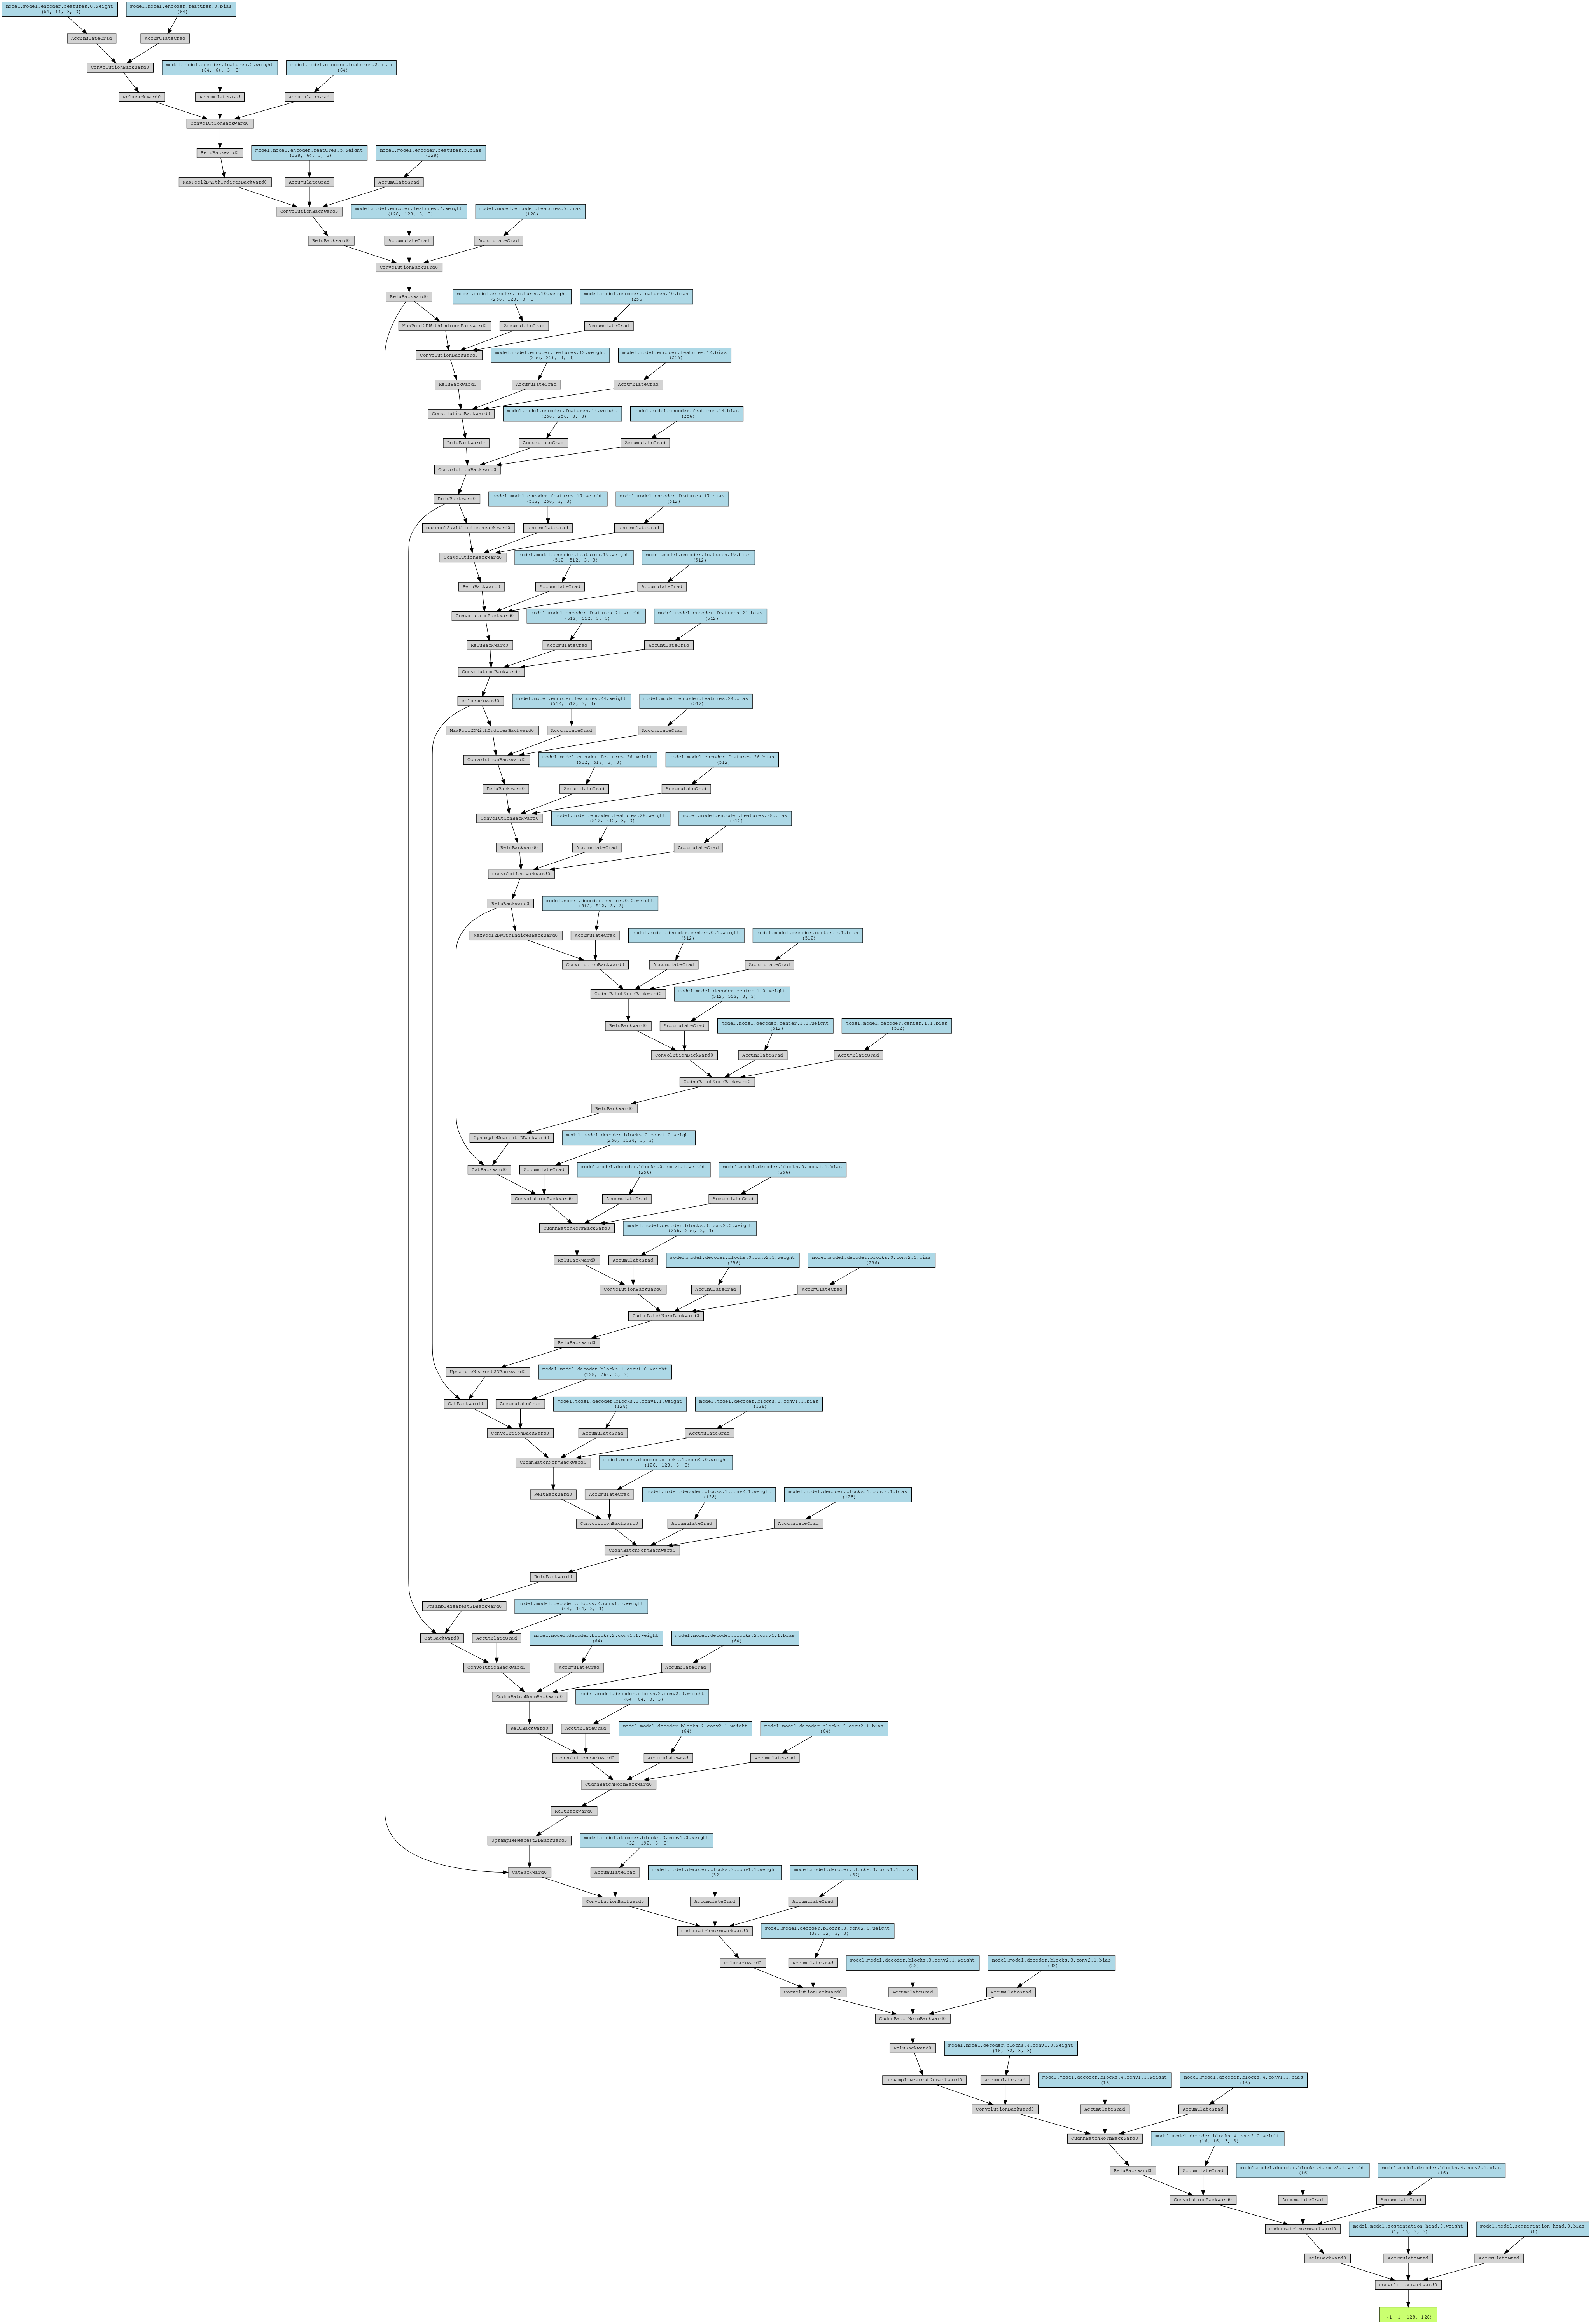

In [7]:
from IPython.display import Image, display

# Display the image
image_path = "/kaggle/working/landslide_model.png"
display(Image(filename=image_path))

Using device: cuda


<ipython-input-8-a58c46cf0286>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 16 images in the first batch.


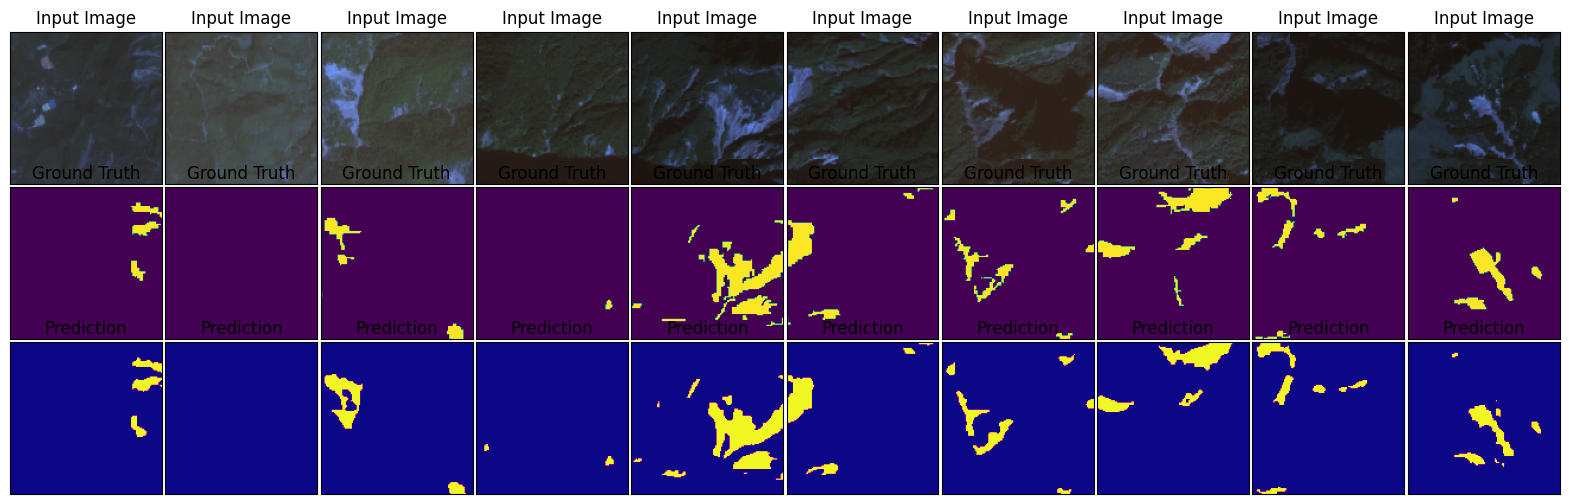

In [8]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming `DatasetLandslide` and `LandslideModel` are defined in the train script

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = "/kaggle/working/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Prepare the dataset and DataLoader
data_path = "/kaggle/input/landslide4sense/TrainData"
dataset = DatasetLandslide(data_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Prepare to store results
all_images = []
all_gt = []
all_predictions = []

# Iterate over the DataLoader and make predictions
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Apply sigmoid if using BCEWithLogitsLoss
        
        # Move data to CPU for visualization
        images = images.cpu()
        masks = masks.cpu()
        predictions = predictions.cpu().numpy()

        # Store results
        all_images.append(images)
        all_gt.append(masks)
        all_predictions.append(predictions)

        # Only get one batch of predictions for visualization
        if len(all_predictions) >= 1:
            break

# Check if data is loaded correctly
if len(all_images) == 0:
    print("No images loaded. Check the dataset path or file structure.")
else:
    print(f"Loaded {len(all_images[0])} images in the first batch.")

# Create a plot with the input image, ground truth, and prediction for each image
fig, ax = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    if i < len(all_images[0]):  # Make sure the batch contains at least 10 images
        img = all_images[0][i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1] range
        
        # Plot the input image (RGB channels)
        ax[0, i].imshow(img[:, :, 1:4])  # Assuming RGB channels are 1, 2, 3
        ax[0, i].set_title("Input Image")

        # Plot the ground truth mask with a color map
        ax[1, i].imshow(all_gt[0][i][0].numpy(), cmap='viridis')
        ax[1, i].set_title("Ground Truth")

        # Plot the prediction with a color map
        ax[2, i].imshow(all_predictions[0][i][0] > 0.5, cmap='plasma')
        ax[2, i].set_title("Prediction")

        # Remove axis
        for j in range(3):
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])

fig.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()

Using device: cuda


<ipython-input-9-e05eed6e0b37>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 16 images in the first batch.


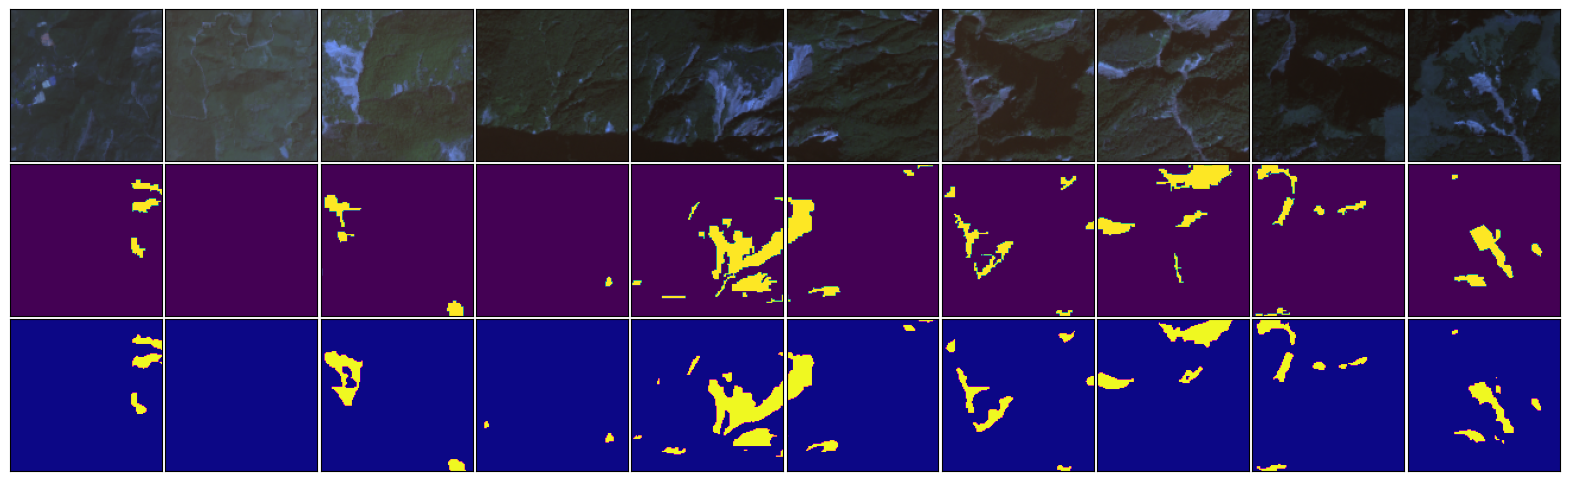

In [9]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming `DatasetLandslide` and `LandslideModel` are defined in the train script

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = "/kaggle/working/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Prepare the dataset and DataLoader
data_path = "/kaggle/input/landslide4sense/TrainData"
dataset = DatasetLandslide(data_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Prepare to store results
all_images = []
all_gt = []
all_predictions = []

# Iterate over the DataLoader and make predictions
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Apply sigmoid if using BCEWithLogitsLoss
        
        # Move data to CPU for visualization
        images = images.cpu()
        masks = masks.cpu()
        predictions = predictions.cpu().numpy()

        # Store results
        all_images.append(images)
        all_gt.append(masks)
        all_predictions.append(predictions)

        # Only get one batch of predictions for visualization
        if len(all_predictions) >= 1:
            break

# Check if data is loaded correctly
if len(all_images) == 0:
    print("No images loaded. Check the dataset path or file structure.")
else:
    print(f"Loaded {len(all_images[0])} images in the first batch.")

# Create a plot with the input image, ground truth, and prediction for each image
fig, ax = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    if i < len(all_images[0]):  # Make sure the batch contains at least 10 images
        img = all_images[0][i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1] range
        
        # Plot the input image (RGB channels)
        ax[0, i].imshow(img[:, :, 1:4])  # Assuming RGB channels are 1, 2, 3

        # Plot the ground truth mask with a color map
        ax[1, i].imshow(all_gt[0][i][0].numpy(), cmap='viridis')

        # Plot the prediction with a color map
        ax[2, i].imshow(all_predictions[0][i][0] > 0.5, cmap='plasma')

        # Remove axis
        for j in range(3):
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])

fig.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()

In [10]:
# Load the trained model
model_path = "/kaggle/working/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)

# Load state dictionary
state_dict = torch.load(model_path, map_location=device)

# Check for unexpected prefixes (e.g., 'model.')
# Remove 'model.' prefix if present (common in Lightning saved models)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("model.", "")  # Remove prefix
    new_state_dict[new_key] = value

# Load the adjusted state dictionary
model.load_state_dict(new_state_dict, strict=False)  # Use strict=False to allow minor mismatches
model.eval()

<ipython-input-10-40cf05a721d4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


LandslideModel(
  (model): smp_model_vgg16(
    (model): Unet(
      (encoder): VGGEncoder(
        (features): Sequential(
          (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
          (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): ReLU(inplace=True)
          (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (11): ReLU(inplace=True)
          (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (13): ReLU(inplace=T

In [11]:
# Test forward pass with a random input
with torch.no_grad():
    test_input = torch.randn(1, 14, 128, 128).to(device)  # Match input shape (B, C, H, W)
    test_output = model(test_input)
    print("Output shape:", test_output.shape)

Output shape: torch.Size([1, 1, 128, 128])
